In [1]:
# Import libraries

import requests
from bs4 import BeautifulSoup as bs
import pandas as pd

In [49]:
# Define Company Website
company_website= 'www.uber.com'

# Verify TrustPilot website
url= 'https://www.trustpilot.com/review/'+company_website
page= requests.get(url) 

if(page.status_code == 200): 
    print("URL Request Successful :)")
else: 
    print("URL Request Failed :(")

URL Request Successful :)


In [50]:
# Parse the HTML tags
soup= bs(page.content, 'html.parser')

# 1. Collect company details, review counts and number of pages


In [51]:
# Company Name
Company_name= soup.find_all("span",class_="typography_display-s__qOjh6 typography_appearance-default__AAY17 title_displayName__TtDDM")
Company_name= Company_name[0].text.replace('\xa0','')
print('Company Name:',Company_name)

# Total # Reviews
total_reviews= soup.find_all("span",class_="typography_body-l__KUYFJ typography_appearance-subtle__8_H2l styles_text__W4hWi")
total_reviews= int(total_reviews[0].text.split()[0].replace(',',''))
print("Total number of reviews:",total_reviews)

# Average Star Rating
avg_star_rating= soup.find_all("p",class_="typography_body-l__KUYFJ typography_appearance-subtle__8_H2l")
avg_star_rating= float(avg_star_rating[0].text)
print("Average Star Rating:",avg_star_rating)

# Company Website
print("Company Website:",company_website)


# Company Website HTML
    #test= soup.find_all("span",class_="styles_prefix__a6Wee")
    #host_name= test[0].text
    #test= soup.find_all("span",class_="styles_suffix__2BIZf")
    #domain_name= test[0].text
    #company_website= host_name + domain_name
    #company_website
test= soup.find_all("div",class_="styles_cardBadge__LeaaQ")
company_website_html= test[0].find('a').get('href')
print("Company Website in HTML:",company_website_html)

# Total Number of Pages
span_pages= soup.find_all("span",class_="typography_heading-xxs__QKBS8 typography_appearance-inherit__D7XqR typography_disableResponsiveSizing__OuNP7")
total_pages=[]
for page in span_pages:
    if(page.text.isnumeric()):
        total_pages.append(int(page.text))
total_pages = max(total_pages)
print("Total number of review pages to scrape:", total_pages)


Company Name: Uber
Total number of reviews: 23919
Average Star Rating: 3.0
Company Website: www.uber.com
Company Website in HTML: http://www.uber.com?utm_medium=company_profile&utm_source=trustpilot&utm_campaign=domain_click
Total number of review pages to scrape: 811


# 2. Scrape all reviews

Scrape the following contents from all pages:
1. Reviewer Name 
2. Reviewer Total Reviews
3. Location
4. Review Star Rating
5. Review Title
6. Review
7. Date
8. Review Likes

Remember to request websites in chunks, else the following error will occur:

        "We have received an unusually large amount of requests from your IP so you have been rate limited"

## 2.1 Script to pull data from pages that have even number of reviews

* This code parses through each page and pulls all the review informations available
* Page numbers with uneven review informations will be stored in the list uneven_record_pages, that'll be used later with an alternative data pull approach.

In [64]:
page_num_df=list()
reviewer_name_df=list()
reviewer_review_count_df=list()
review_location_df=list()
star_rating_df=list()
review_title_df=list()
reviews_df=list()
review_month_df=list()
review_day_df=list()
review_year_df=list()

failed_pages=[]
uneven_record_pages = []
#[4, 8, 10, 12, 19, 20, 22, 24, 25, 29, 30, 35, 36, 39, 40, 41, 44, 46, 47, 48, 49, 50, 51, 52, 53, 55, 62, 63, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 182, 183, 184, 185, 186, 187, 188, 189, 190, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 324, 325, 326, 327, 328, 329, 330, 331, 332, 336, 340, 342, 343, 345, 346, 347, 348, 349, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 370, 372, 375, 376, 377, 378, 379, 380, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 464, 465, 466, 467, 468, 469, 470, 472, 473, 475, 476, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 495, 496, 497, 498, 499, 500, 501, 504, 515, 516, 530, 532, 534, 535, 538, 539, 542, 549, 550, 551, 553, 555, 558, 559, 564, 570, 576, 577, 580, 583, 588, 589, 595, 599, 603, 606, 612, 614, 615, 616, 619, 624, 626, 629, 630, 631, 635, 640, 643, 646, 647, 649, 652, 653, 655, 656, 657, 658, 660, 661, 663, 664, 670, 671, 673, 674, 675, 678, 681, 686, 688, 694, 698, 700, 701, 702, 703, 707, 711, 712, 713, 716, 721, 722, 724, 728, 729, 733, 734, 736, 738, 739, 740, 741, 743, 746, 749, 750, 751, 761, 766, 768, 770, 774, 784, 785, 788, 794, 796, 798, 811]

starting_page=1
#total_pages= 2


for page_number in range (starting_page,total_pages+1):
    # Create URL
    print(page_number,' of',total_pages)
    page= '?page='+str(page_number)
    page_url= 'https://www.trustpilot.com/review/'+company_website+page
    page= requests.get(page_url) 

    
    # Verify URL
    if(page.status_code != 200): 
        print("Page",page_number,"URL Request Failed :( with error code:", page.status_code)
        failed_pages.append(page_number)
        break

    # Initate lists to store scrape results
    page_num=list()
    reviewer_name=list()
    reviewer_review_count=list()
    review_location=list()
    star_rating=list()
    review_title=list()
    reviews=list()
    review_month=list()
    review_day=list()
    review_year=list()
    failed_pages=[]

    # Parse the HTML tags
    soup= bs(page.content, 'html.parser')

    
    # 1. Scrape Reviewer Name
    span_reviewer_names= soup.find_all("span",class_='typography_heading-xxs__QKBS8 typography_appearance-default__AAY17')
    for name in span_reviewer_names:
        reviewer_name.append(name.text)

    # 2. Scrape Reviewer's Total Reviews
    span_reviewer_review_count= soup.find_all("span",class_='typography_body-m__xgxZ_ typography_appearance-subtle__8_H2l')
    for count in span_reviewer_review_count:
        count= int(count.text.split()[0])
        reviewer_review_count.append(count)

    # 3. Scrape Review Location
    div_review_location= soup.find_all("div",class_='typography_body-m__xgxZ_ typography_appearance-subtle__8_H2l styles_detailsIcon__Fo_ua')
    for location in div_review_location:
        review_location.append(location.text)

    # 4. Scrape Review Star Rating
    div_review_star_rating= soup.find_all("div",class_='styles_reviewHeader__iU9Px')
    for rating in div_review_star_rating:
        star_rating.append(int(rating.get('data-service-review-rating')))

    # 5. Scrape Review Title
    h2_review_title= soup.find_all("h2",class_='typography_heading-s__f7029 typography_appearance-default__AAY17')
    for title in h2_review_title:
        review_title.append(title.text)

    # 6. Scrape Reviews
    p_reviews= soup.find_all("p",class_='typography_body-l__KUYFJ typography_appearance-default__AAY17 typography_color-black__5LYEn')
    for review in p_reviews:
        reviews.append(review.text)

    # 7. Scrape Date
    p_date= soup.find_all("p",class_='typography_body-m__xgxZ_ typography_appearance-default__AAY17')
    for date in p_date:
        if(date.get('data-service-review-date-of-experience-typography')=="true"):
            date= date.text
            date= date.replace("Date of experience: ","")
            date= date.replace(",","")
            date= date.split(" ")
            review_month.append(date[0])
            review_day.append(int(date[1]))
            review_year.append(int(date[2]))   

    # Check if the length of reviews are same. Do not store if not.
    max_records= max([len(reviewer_name),len(reviewer_review_count),len(review_location),len(star_rating),len(review_title),len(reviews),len(review_month)])
    if(len(reviewer_name) == max_records and len(reviewer_review_count) == max_records and len(review_location) == max_records and len(star_rating) == max_records and len(review_title) == max_records and len(reviews) == max_records and len(review_month) == max_records):
        page_num_df+=[page_number]*max_records
        reviewer_name_df+=reviewer_name
        reviewer_review_count_df+=reviewer_review_count
        review_location_df+=review_location
        star_rating_df+=star_rating
        review_title_df+=review_title
        reviews_df+=reviews
        review_month_df+=review_month
        review_day_df+=review_day
        review_year_df+=review_year
    else:
        print("Page",page_number,"have uneven records")
        uneven_record_pages.append(page_number)
        continue

print('Failed page numbers:', failed_pages)
print('Uneven # reviews page numbers:', uneven_record_pages)
review_trust_pilot=pd.DataFrame(
    {
    'review_page_number': page_num_df,
    'reviewer_name':reviewer_name_df,
    'reviewer_review_count':reviewer_review_count_df,
    'review_location':review_location_df,
    'star_rating': star_rating_df,
    'review_title':review_title_df,
    'review': reviews_df,
    'review_month': review_month_df,
    'review_dat': review_day_df,
    'review_year': review_year_df
    })

review_trust_pilot['review_source']= 'Trustpilot'
review_trust_pilot['company_name']= Company_name
review_trust_pilot['company_website']= company_website
review_trust_pilot['company_website_html']= company_website_html
review_trust_pilot['total_reviews']= total_reviews
review_trust_pilot['avg_star_rating']= avg_star_rating
review_trust_pilot['total_review_pages']= total_pages

review_trust_pilot

# Merge new collected data to the existing dataframe
existing_df= pd.read_csv("review_trustpilot_uber.csv")
merged_df= existing_df.append(review_trust_pilot)
merged_df.to_csv("review_trustpilot_uber.csv", index= False)

792  of 811
793  of 811
794  of 811
Page 794 have uneven records
795  of 811
796  of 811
Page 796 have uneven records
797  of 811
798  of 811
Page 798 have uneven records
799  of 811
800  of 811
801  of 811
802  of 811
803  of 811
804  of 811
805  of 811
806  of 811
807  of 811
808  of 811
809  of 811
810  of 811
811  of 811
Page 811 have uneven records
Failed page numbers: []
Uneven # reviews page numbers: [4, 8, 10, 12, 19, 20, 22, 24, 25, 29, 30, 35, 36, 39, 40, 41, 44, 46, 47, 48, 49, 50, 51, 52, 53, 55, 62, 63, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175,

C:\Users\admin\AppData\Local\Temp\ipykernel_8816\293267108.py:139: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_df= existing_df.append(review_trust_pilot)


## 2.2 Script to pull data from page that have uneven number of reviews

* This code parses by each container in each page and pulls data

In [65]:
print(len(uneven_record_pages))

528


In [75]:
page_num_df= []
failed_pages=[]
reviewer_name_df=[]
reviewer_review_count_df=[]
review_location_df=[]
star_rating_df=[]
review_title_df=[]
reviews_df=[]
review_month_df=[]
review_day_df=[]
review_year_df=[]

start_index=424

for i in range(start_index,len(uneven_record_pages)+1):
  print(i,' of',len(uneven_record_pages))
  page_number= uneven_record_pages[i]
  page= '?page='+str(page_number)
  page_url= 'https://www.trustpilot.com/review/'+company_website+page
  page= requests.get(page_url) 

  # Verify URL
  if(page.status_code != 200): 
      print("Page",page_number,"URL Request Failed :( with error code:", page.status_code)
      print("Failed Record List Index:", i)
      failed_pages.append(page_number)
      break
  
  # Parse the HTML tags
  soup= bs(page.content, 'html.parser')
  
  # Get the containers list
  containers= soup.find_all("div",class_='styles_cardWrapper__LcCPA styles_show__HUXRb styles_reviewCard__9HxJJ')  

  for container in containers:
    page_num_df.append(page_number)

    # Collect data from each container
    span_reviewer_name= container.find("span",class_='typography_heading-xxs__QKBS8 typography_appearance-default__AAY17')
    span_reviewer_review_count= container.find("span",class_='typography_body-m__xgxZ_ typography_appearance-subtle__8_H2l')
    div_review_location= container.find("div",class_='typography_body-m__xgxZ_ typography_appearance-subtle__8_H2l styles_detailsIcon__Fo_ua')
    div_review_star_rating= container.find("div",class_='styles_reviewHeader__iU9Px')
    h2_review_title= container.find("h2",class_='typography_heading-s__f7029 typography_appearance-default__AAY17')
    p_review= container.find("p",class_='typography_body-l__KUYFJ typography_appearance-default__AAY17 typography_color-black__5LYEn')
    p_date= container.find("p",class_='typography_body-m__xgxZ_ typography_appearance-default__AAY17')

    # Append the data with values from previous containers. Append NA if data is not available in the website
    if(type(span_reviewer_name)==type(None)): reviewer_name_df.append(None)
    else: reviewer_name_df.append(span_reviewer_name.text)

    if(type(span_reviewer_review_count)==type(None)): reviewer_review_count_df.append(None)
    else: reviewer_review_count_df.append(int(span_reviewer_review_count.text.split()[0]))  

    if(type(div_review_location)==type(None)): review_location_df.append(None)
    else: review_location_df.append(div_review_location.text) 

    if(type(div_review_star_rating)==type(None)): star_rating_df.append(None)
    else: star_rating_df.append(int(div_review_star_rating.get('data-service-review-rating')))

    if(type(h2_review_title)==type(None)): review_title_df.append(None)
    else: review_title_df.append(h2_review_title.text)

    if(type(p_review)==type(None)): reviews_df.append(None)
    else: reviews_df.append(p_review.text)

    if(type(p_date)==type(None)): 
      review_month_df.append(None)
      review_day_df.append(None)
      review_year_df.append(None)
    else: 
      date= p_date.text
      date= date.replace("Date of experience: ","")
      date= date.replace(",","")
      date= date.split(" ")
      review_month_df.append(date[0])
      review_day_df.append(int(date[1]))
      review_year_df.append(int(date[2]))


print('Failed page numbers:', failed_pages)
review_trust_pilot=pd.DataFrame(
    {
    'review_page_number': page_num_df,
    'reviewer_name':reviewer_name_df,
    'reviewer_review_count':reviewer_review_count_df,
    'review_location':review_location_df,
    'star_rating': star_rating_df,
    'review_title':review_title_df,
    'review': reviews_df,
    'review_month': review_month_df,
    'review_dat': review_day_df,
    'review_year': review_year_df
    })

review_trust_pilot['review_source']= 'Trustpilot'
review_trust_pilot['company_name']= Company_name
review_trust_pilot['company_website']= company_website
review_trust_pilot['company_website_html']= company_website_html
review_trust_pilot['total_reviews']= total_reviews
review_trust_pilot['avg_star_rating']= avg_star_rating
review_trust_pilot['total_review_pages']= total_pages

review_trust_pilot

# Merge new collected data to the existing dataframe
existing_df= pd.read_csv("review_trustpilot_uber.csv")
merged_df= existing_df.append(review_trust_pilot)
merged_df.to_csv("review_trustpilot_uber.csv", index= False)

Failed page numbers: []


C:\Users\admin\AppData\Local\Temp\ipykernel_8816\1146341134.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_df= existing_df.append(review_trust_pilot)


Verification: All page numbers (excep the last one) have same number of reviews in the colelcted dataset

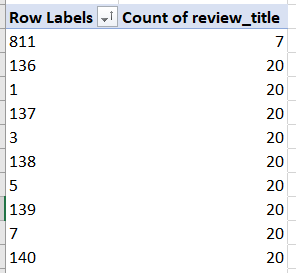